In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np

from arianna.distributions import Gamma, Normal
from arianna.ppl.context import Context, Predictive
from arianna.ppl.inference import AIES, Chain

In [3]:
def linear_regression(
    ctx: Context, X: np.ndarray, y: Optional[np.ndarray], bias=True
):
    _, p = X.shape
    beta = ctx.rv("beta", Normal(np.zeros(p), 10))
    mu = ctx.cached("mu", X @ beta)
    if bias:
        alpha = ctx.rv("alpha", Normal(0, 10))
        mu += alpha
    sigma = ctx.rv("sigma", Gamma(1, 1))

    ctx.rv("y", Normal(mu, sigma), obs=y)

Simulation truth: {'beta': array([3.57380411]), 'alpha': array(-12.08318632), 'sigma': 2}


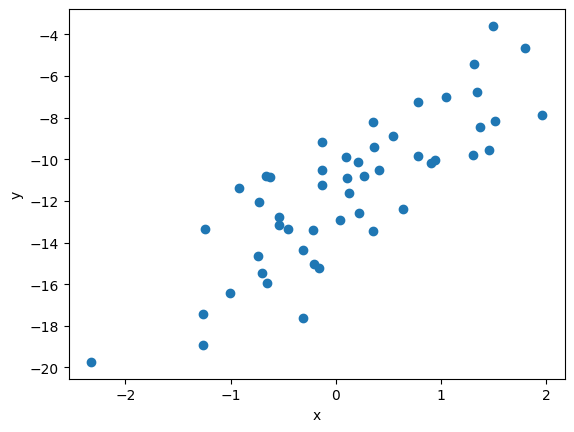

In [4]:
rng = np.random.default_rng(0)
X = (x := rng.normal(0, 1, 50)).reshape(-1, 1)
sim_truth = Predictive.run(
    linear_regression,
    state=dict(sigma=2),
    rng=rng,
    X=X,
    y=None,
    return_cached=False,
)
y = sim_truth.pop("y")

print("Simulation truth:", sim_truth)

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [5]:
# Affine Invariant Ensemble Sampler.

aies = AIES(
    linear_regression,
    rng=rng,
    X=X,
    y=y,
    transform=False,
    nwalkers=5,
)
samples = aies.fit(2000, burn=1000)

100%|██████████| 3000/3000 [00:01<00:00, 2848.35it/s]


In [6]:
# Or try with random-walk Metropolis.

# from aria.ppl.inference import RandomWalkMetropolis
#
# proposal = {
#     name: (
#         lambda value, rng, mcmc_iteration: rng.normal(
#             value, np.clip(10 * np.exp(-mcmc_iteration / 100), 0.1, 10)
#         )
#     )
#     for name in sim_truth
# }
# rwm = RandomWalkMetropolis(
#     linear_regression, proposal=proposal, rng=rng, X=X, y=y
# )
# samples = rwm.fit(2000, burn=1000, thin=10)

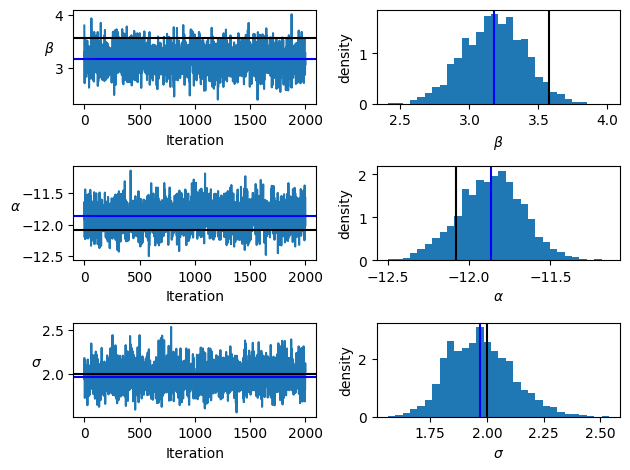

In [7]:
bundle = samples.bundle
if "mu" in bundle:
    bundle.pop("mu")

plt.figure()
for i, (name, value) in enumerate(bundle.items()):
    match value.ndim:
        case 2:
            value = value.flatten()
        case 1:
            pass
        case _:
            raise NotImplementedError()

    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(value)
    param_truth: float = sim_truth[name]  # type: ignore
    plt.axhline(param_truth, c="k")
    plt.axhline(value.mean(), c="b")
    plt.xlabel("Iteration")
    plt.ylabel(f"$\\{name}$", rotation=0)

    plt.subplot(3, 2, 2 * i + 2)
    plt.hist(value, density=True, bins=30)
    plt.axvline(param_truth, c="k")
    plt.axvline(value.mean(), c="b")
    plt.xlabel(f"$\\{name}$")
    plt.ylabel("density")

plt.tight_layout()
plt.show()

In [8]:
X_new = (x_new := np.linspace(-3, 3, 50)).reshape(-1, 1)
post_predictive = Chain(
    Predictive.run(linear_regression, state=c, rng=rng, X=X_new, y=None)
    for c in samples
)
y_new = post_predictive.get("y")
mu_new = post_predictive.get("mu")

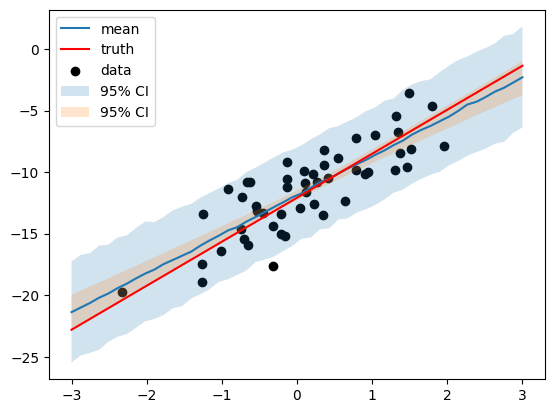

In [9]:
plt.plot(x_new, y_new.mean(0), label="mean")
plt.plot(
    x_new, x_new * sim_truth["beta"] + sim_truth["alpha"], label="truth", c="r"
)
plt.scatter(x, y, c="k", label="data")
plt.fill_between(
    x_new,
    np.quantile(y_new, 0.025, 0),
    np.quantile(y_new, 0.975, 0),
    alpha=0.2,
    label="95% CI",
)
plt.fill_between(
    x_new,
    np.quantile(mu_new, 0.025, 0),
    np.quantile(mu_new, 0.975, 0),
    alpha=0.2,
    label="95% CI",
)
plt.legend()
plt.show()